# Projeto 13 

### Descrição do projeto 
A rede de academias Model Fitness está desenvolvendo uma estratégia de interação com o cliente baseados em dados analíticos.

Um dos problemas mais comuns que academias e outros serviços enfrentam é a rotatividade de clientes. Como você sabe se um cliente não está mais com você? Você pode calcular a rotatividade baseado nas pessoas que se livram das suas contas ou não renovam seus contratos. No entanto, às vezes não é óbvio que um cliente saiu: eles podem sair de fininho.

Indicadores de rotatividade varia de área para área. Se um usuário compra de uma loja online raramente mas regularmente, você não pode dizer que é um fujão. Mas se por duas semanas eles não abriam o canal que é atualizado diariamente, essa é uma razão para se preocupar: seu seguidor pode ter ficado aborrecido e deixado você.

Para uma academia, faz sentido dizer que os clientes saíram se eles não aparecem há um mês. É claro, é possível que eles estejam em Cancun e virão tornar a frequentar quando retornarem, mas esse não é um caso comum. Normalmente, se um cliente ingressa, vem algumas vezes, depois desaparece, ele provavelmente não voltará.

Em vez de lutar com a rotatividade, Model Fitness digitalizou uma parte dos perfis dos clientes. Sua tarefa é analisá-los e vir com uma estratégia de retenção de clientes.

Meu objetivo:

* Aprender a predizer a probabilidade de rotatividade (para o mês seguinte) para cada cliente
* Elaborar retratos de usuários típicos: selecionando os grupos mais marcantes e descrever suas principais características
* Analisar os fatores que mais impactam a rotatividade
* Tirar conclusões básicas e desenvolva recomendações sobre como melhorar o serviço de clientes:
* Identificar grupos alvo
* Sugerir medidas para diminuir a rotatividade
* Descrever qualquer outro padrão com respeito às interações com clientes

#### Passo 1. Baixar os dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2.5})

In [2]:
df = pd.read_csv('gym_churn_us.csv')

#### Passo 2. Realize análise exploratória dos dados (AED)

##### Estudando características

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

* DF contém somente dados numéricos, o que é bom para o tipo de tarefa de negócio e modelo de ML que queremos treinar (supervisionado de classificação binária)
* DF não contém dados ausentes 
* DF contém 14 colunas (1 variavel objetivo e 13 variaveis características)
* Colunas fora do formato snake_case
* Bom número de amostras (4000 mil)

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Colunas que potencialmente poderiam ser categoricas, já estam no formato de código binário, o que é excelente para o modelo pretendido 

In [5]:
#function columns to snake_case
def new_col_names(df):
    new_names = []
    for old_name in df.columns:
        # remove os espaços no início e no final
        name_stripped = old_name.strip()
        # todas as letras em minúsculas
        name_lowered = name_stripped.lower()
        # substitui os espaços entre as palavras por sublinhados
        name_no_spaces = name_lowered.replace(' ', '_')
        # Adicionando a lista de novos nomes
        new_names.append(name_no_spaces)
    # Substitui os nomes antigos pelos novos
    df.columns = new_names
    print(df.columns)

In [6]:
new_col_names(df)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


In [7]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int64')
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Média e desvio padrão calculados, alguns pontos que talvez possam fazer diferença em futura análise ou conclusões: 
* Nessa academia não existe idosos, idade maxima é 41 anos. 
* Somente 30% dos clientes se inscreveram através da promoção "tragam um amigo" 
* 50% dos clientes tem só 1 mês ou menos de contrato e 75% 6 meses ou menos de contrato. (mais que metade dos clientes sem contratos longos)
* 50% dos clientes tem 3 meses ou menos desde que se inscreveu 

##### Média de valores das características nos dois grupos:

In [8]:
#mean variables per group churn
df_churn = df.groupby('churn').mean([df.columns])
df_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Ao observar os valores médios das características nos dois grupos, nota-se que há uma tendência a sair quem: 
* Não faz parte de empresas parceiras
* Não veio através de indicação de amigos
* Cliente recente com contrato curto (menos de 3 meses) 
* Não participa em aulas de grupos 

##### Distribuição de características nos dois grupos:

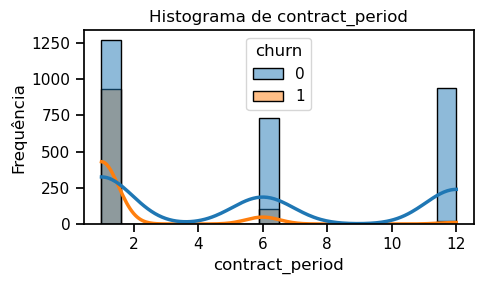

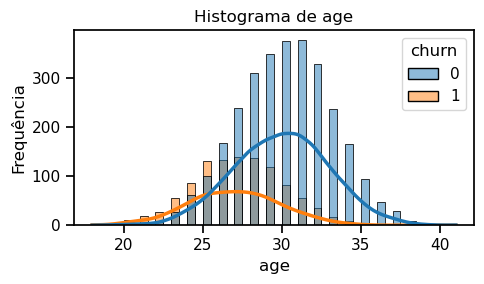

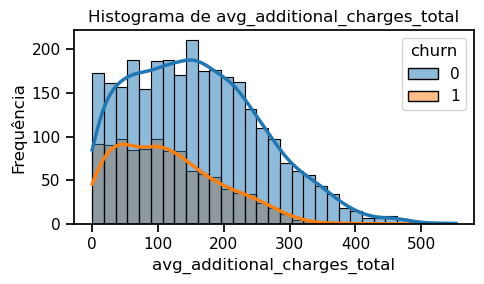

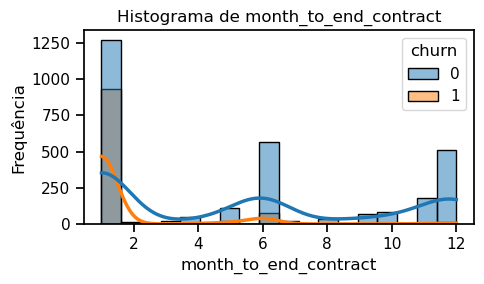

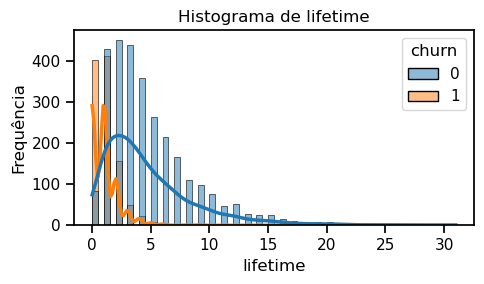

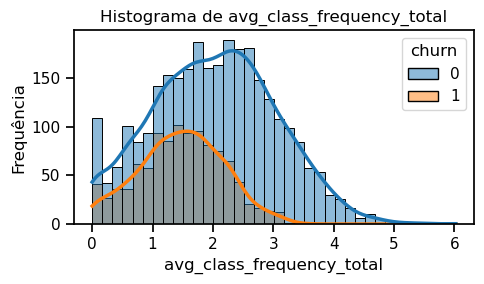

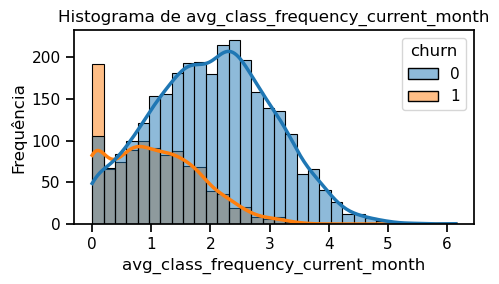

In [9]:
#distribution of characteristics by churn group
for col in df.drop('churn', axis=1).columns:
    if (df[col] > 1).any(): #any to check if at least one value is more than 1, no binary columns for histogram
        plt.figure(figsize=(5, 3)) #new fig for each hist plot
        sns.histplot(data=df, x=col, hue='churn', kde=True, alpha=0.5)
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        plt.ylabel('Frequência')
        plt.tight_layout()
        plt.show()

Alguns histogramas não se parecem tanto com uma distribuição normal e pode ser que tenham valores muito atípicos, o objetivo é que se parecam mais ou menos com uma distribuicão normal, valores atípicos em um tipo de modelo de regressão linear pode causar distorção no treinamento do modelo puxando a relação para um lado ou para o outro, vou definir uma limiar percentil 95% e 99% e qualquer valor acima dessa limiar será verificado e removido ou substituido pela média dependendo do valor atípico nessas mesmas colunas para não prejudicar nosso modelo de ML 

In [10]:
for col in df.drop('churn', axis=1).columns:
    if (df[col] > 1).any():
        print(f'{col}, {np.percentile(df[col],[95, 99])}')

contract_period, [12. 12.]
age, [34. 37.]
avg_additional_charges_total, [323.44087589 400.99612505]
month_to_end_contract, [12. 12.]
lifetime, [11. 17.]
avg_class_frequency_total, [3.53564837 4.19757925]
avg_class_frequency_current_month, [3.54906154 4.18575779]


A principio os valores estão dentro de valores aceitaveis dentro da realidade de um cliente de academia, valores não serão alterados

##### Matriz de Correlação de Características

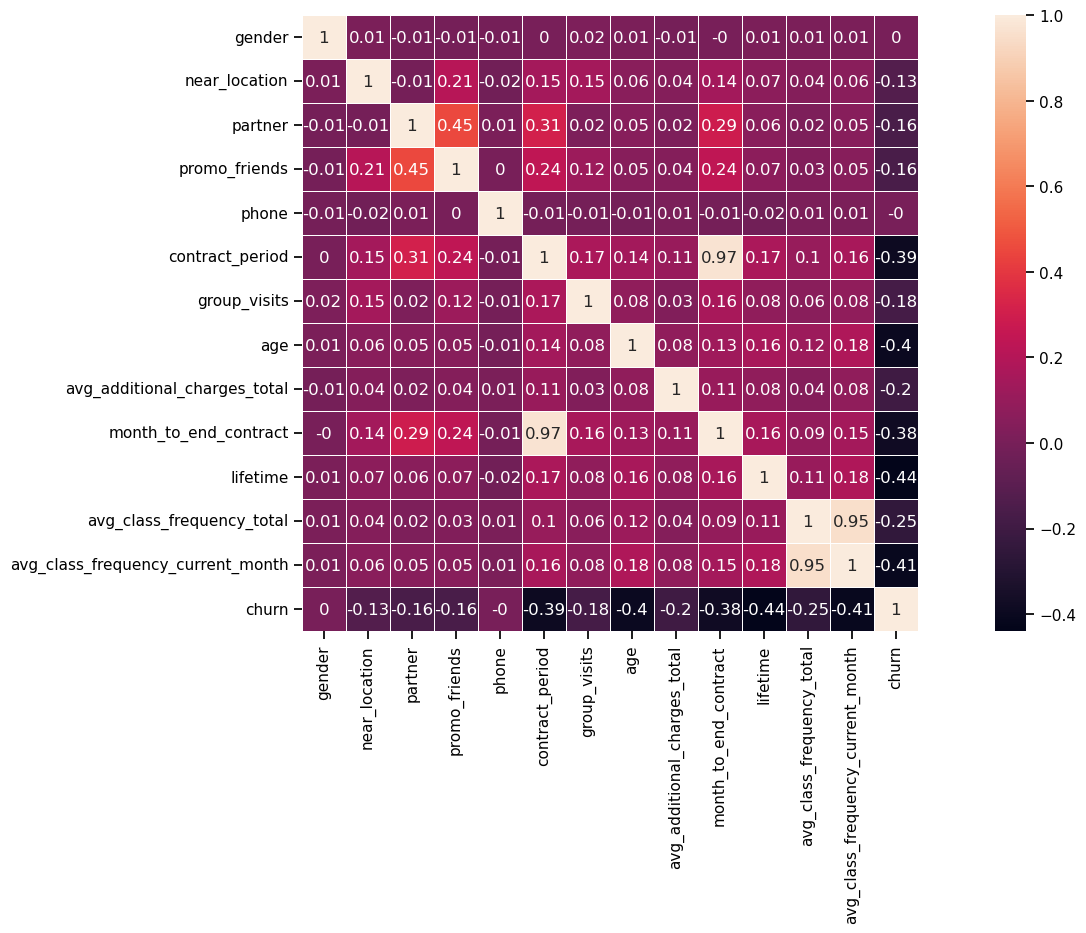

In [11]:
cm = df.corr().round(2)

plt.figure(figsize=(20,8))
sns.heatmap(cm, annot=True, square=True, linewidths=0.5)
plt.show()

Segundo o heatmap temos problemas de multicolinearidade entre as caracteristicas: 
* avg_class_frequency_total e avg_class_frequency_current_month
* month_to_end_contract e contract_period

Em regressão linear multicolinearidade (características com forte correlações entre si) pode causar ponderações não representativas e um modelo superajustado para essas características.

* No caso de frequência média, como estamos tentando prever se o cliente vai sair no proximo mês baseados em alguns dados do mês anterior a coluna avg_class_frequency_total (frequência média de idas por semana por toda a vida do cliente) será removida e somente a do mês corrente permancerá.

* Sobre as colunas de contrato foi decidido eliminar a coluna contract_period pois ela é redundante uma vez que já tenho month_to_end_contract, month_to_end_contract é mais dinâmica, essa variável muda ao longo do tempo conforme os clientes se aproximam do fim do contrato.
Como o objetivo é prever o cancelamento no próximo mês, essa variável pode conter mais informação temporal relevante para prever cancelamento de assinatura


In [12]:
#deleting columns with multicollinearity to make safe regression ML model
df.drop(['avg_class_frequency_total', 'contract_period'], axis=1, inplace=True)

#### Passo 3. Construa um modelo para predizer a rotatividade de clientes (aprendizado supervisionado de classificacao binária )

##### Construindo modelo de classificação binária para clientes onde a variável objetivo é a saída de usuários do próximo mês

In [13]:
#dividing data into features (X) and objective variable (y)
X = df.drop('churn', axis=1)
y = df['churn']

#dividing data in train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#standardizing data from different scales
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)


Checando distribuição dos dados de validação e testes alterados se combinam entre si como uma distribuição normal 

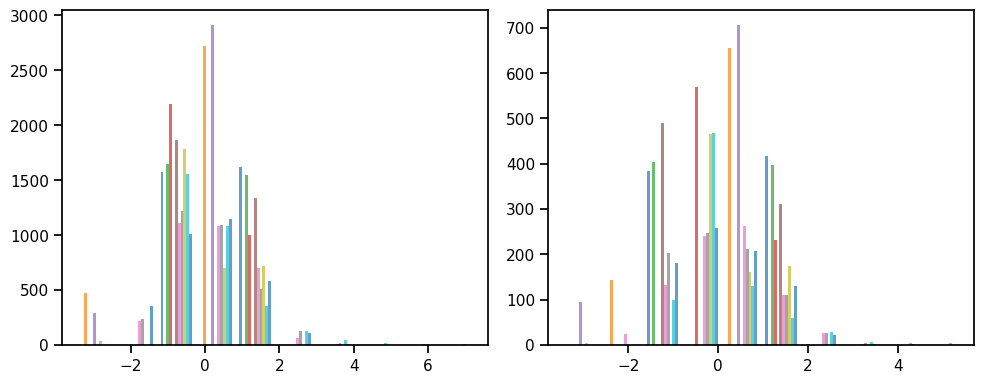

In [14]:
#checking distribution of train and test after standardization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 linha, 2 colunas

# first hist
axes[0].hist(X_train_st, alpha=0.7)

#second hist
axes[1].hist(X_test_st, alpha=0.7)

plt.tight_layout()  # Ajusta o espaçamento entre os gráficos
plt.show()

##### Treinando modelo e checando métricas

In [15]:
#models
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

#function train and prediction 
def make_prediction(m, X_train, y_train, X_test, y_test): 
    model = m 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1] #probabilidade de ser 1
    print('Acurácia {:.2f}, Precisão {:.2f}, Sensibilidade {:.2f}, Probabilidade {:.2f}'.format(accuracy_score(y_pred, y_test), 
                                                                          precision_score(y_pred, y_test),
                                                                          recall_score(y_pred, y_test),
                                                                          roc_auc_score(y_test, probabilities)))

In [16]:
for i in models: 
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
Acurácia 0.91, Precisão 0.82, Sensibilidade 0.80, Probabilidade 0.96
RandomForestClassifier(random_state=0)
Acurácia 0.91, Precisão 0.78, Sensibilidade 0.82, Probabilidade 0.95


Apesar da pouca diferença, após verificação das métricas o modelo que produziu melhores resultados foi o modelo Logistic Regression 

##### Importancia das caracteristicas 

In [17]:
#training final model 
final_model = LogisticRegression(random_state=0)
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)

#features importances
df_importances = pd.DataFrame({'features': X.columns,
                              'importance': final_model.coef_.ravel()}) # A função ravel() transforma um array multidimensional em um vetor unidimensional (1D).

df_importances.sort_values(by='importance')

,features,importance
9,lifetime,-3.924250
10,avg_class_frequency_current_month,-1.334673
8,month_to_end_contract,-1.327051
6,age,-1.109440
7,avg_additional_charges_total,-0.581475
5,group_visits,-0.381252
3,promo_friends,-0.237538
1,near_location,-0.089490
4,phone,-0.087079
2,partner,-0.080828


Segundo o resultado do DF de importancia das caracteristicas que mais influenciam os clientes a cancelaram suas matriculas são o tempo de vida do cliente, a frequencia semanal na academia, meses restantes até o encaramento do contrato e a idade

#### Passo 4. Criando agrupamentos de clientes

##### Construindo uma matriz das distâncias baseada na matriz de características padronizada e construindo um dendrograma

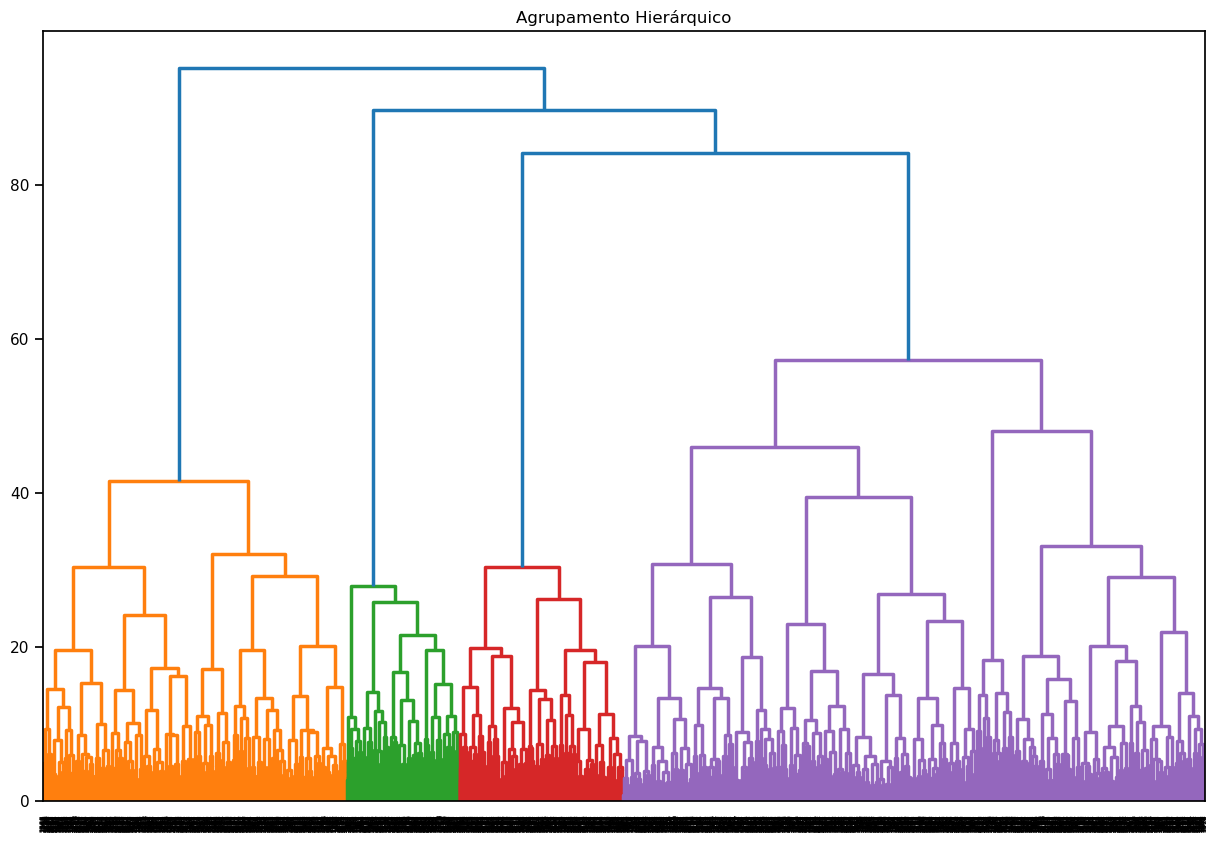

In [18]:
#customer grouping, dendrogram
#standartization 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method='ward')

#plot dendrogram
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Agrupamento Hierárquico')
plt.show()

##### Treinando modelo de agrupamento com o algoritmo K-means para prever agrupamentos de clientes

In [19]:
#training model K-means to find customer groups 
km = KMeans(n_clusters=5, random_state=0) #defining 5 groups based on dendrogram 

labels = km.fit_predict(X_sc)

#adding labels groups to original df 
df['cluster_km'] = labels

In [20]:
#calculating metric pontuation for grouping 
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


Pontuação baixa, porém métrica de agrupamento é algo bem dificil de ser avaliar improvável que você encontre um processo em que as observações
(objetos) tenham uma estrutura e divisão claras. Por esse motivo, os resultados devem ser discutidos com especialistas e avaliados durante análise


##### Valores médios das características para agrupamentos

In [21]:
df.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.723967,0.266839
1,0.488484,1.000000,0.218810,0.070058,1.0,0.288868,27.536468,116.214451,1.994242,1.890595,1.174813,0.572937
2,0.500000,0.000000,0.489247,0.078853,1.0,0.232975,28.679211,137.125763,2.818996,2.974910,1.597146,0.403226
3,0.545366,0.996098,0.375610,0.009756,1.0,0.522927,30.693659,178.066934,5.535610,5.382439,2.328366,0.017561
4,0.497472,0.995956,0.888777,1.000000,1.0,0.522750,29.596562,153.670691,6.311426,4.278059,1.921960,0.119312


Alguns valores me chamaram atencão na análise acima:
* Aparentamente o grupo que tem maior chance de churn seria o grupo 1, e o mesmo grupo é que o tem os menores em quase todas as características, com exceção de "distancia do academia"
* O grupo que tem menor chance de churn seria o grupo 3 que tem os maiores valores em quase todas as características com excecão do 'promo_friends' e 'parter' (clientes de empresas parceiras), o que pode indicar que não é somente promoções que faz um cliente permanecer
* O segundo grupo com menor chance de churn seria o grupo 4 e esse seria o grupo com os maiores valores em 'promo_friends', 'parter' (clientes de empresas parceiras) e 'near_location' localização proxima da academia. O que pode indicar que uma combinação de promoções e parceirias com empresas nas proximidades seria uma ótima iniciativa para diminuir o churn

##### Distribuição de características por agrupamento

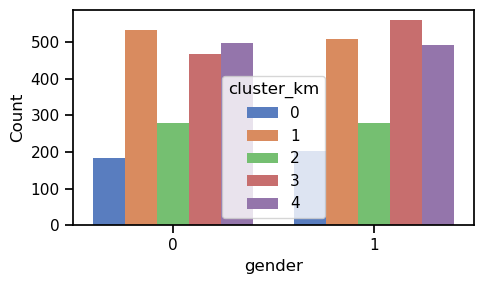

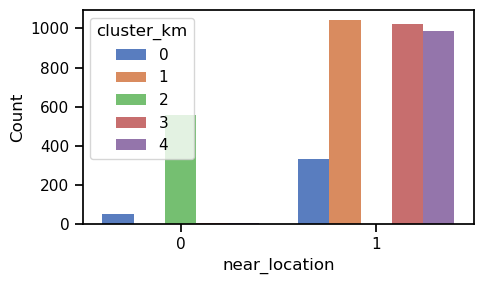

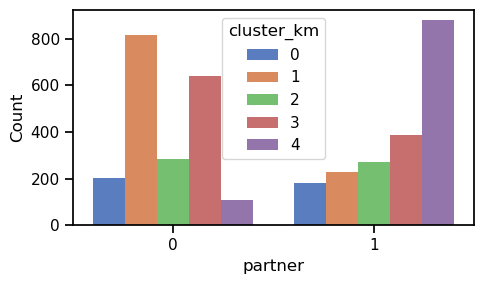

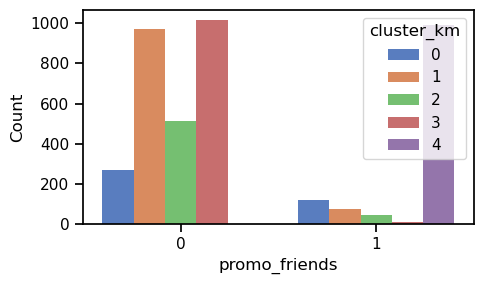

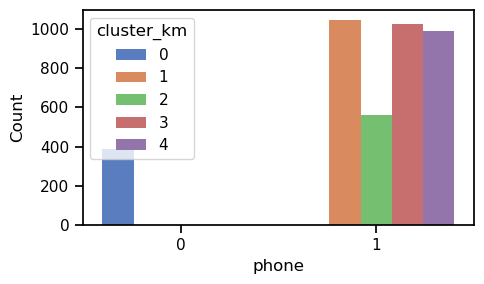

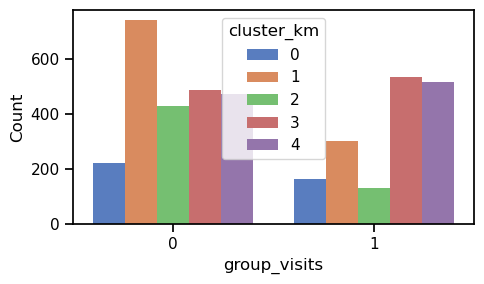

In [22]:
#distribution of characteristics by cluster for binary columns
for col in df.drop('churn', axis=1).columns:
    if set(df[col].unique()).issubset({0, 1}): #only binary columns, verify if all values only are 0 or 1
        plt.figure(figsize=(5, 3)) #new fig for each plot
        sns.countplot(data=df, x=col, hue='cluster_km', palette='muted')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

Nas características de colunas binárias: 
+ Grupo com churn alto 1, grupo churn baixo 3 e 4 
* Grupo 4 foi o único que participou da promoção de indicação de amigo
* Em empresas parceiras somente grupo 4 tem numero significativos
* A grande maioria moram ou trabalham perto da academia com exceção de uma parcela do grupo 0 e 2 
* Grupo 1 quase não frequenta aulas de grupo 

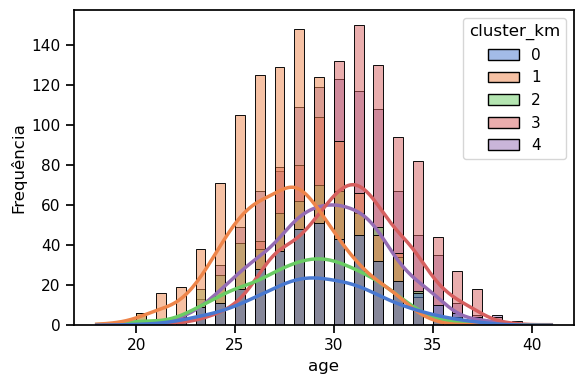

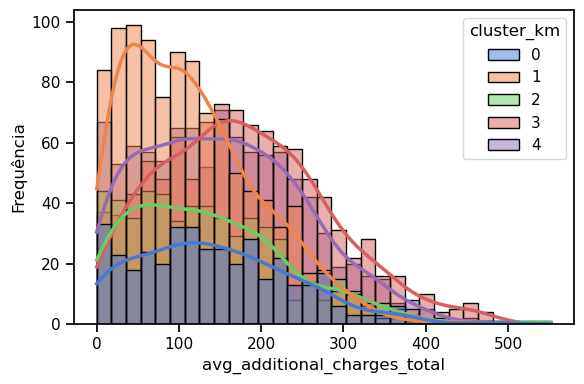

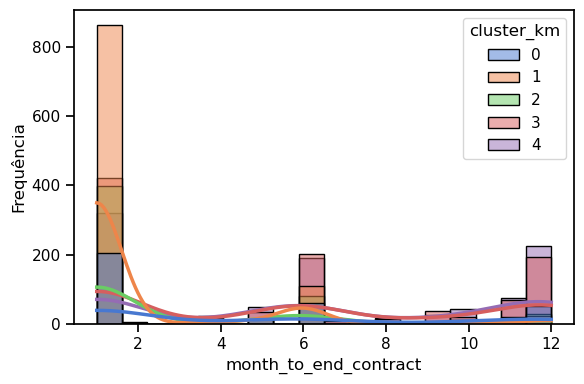

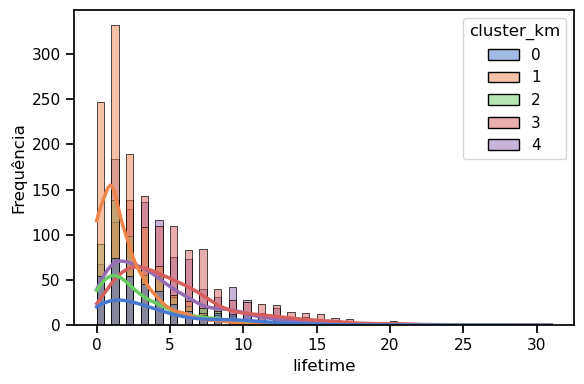

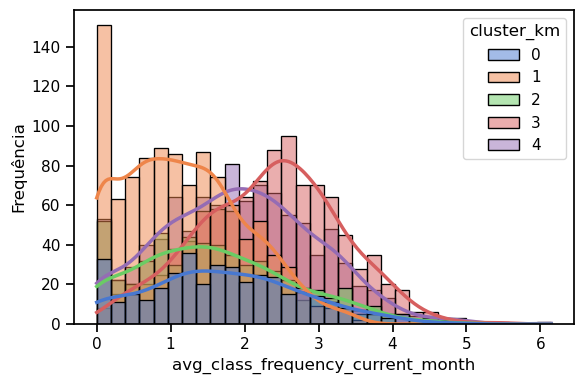

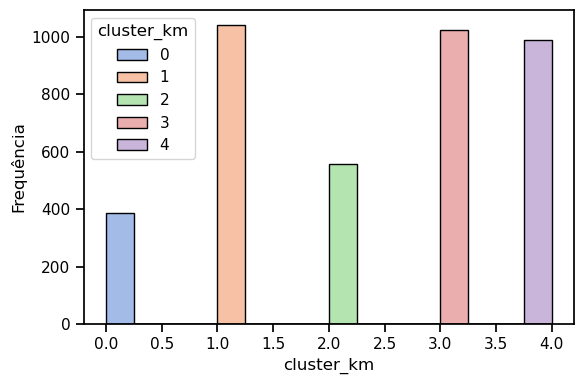

In [23]:
#distribution of characteristics by cluster no binary columns
for col in df.drop('churn', axis=1).columns:
    if (df[col] > 1).any(): #any to check if at least one value is more than 1, no binary columns for histogram
        plt.figure(figsize=(6, 4)) #new fig for each hist plot
        sns.histplot(data=df, x=col, hue='cluster_km', kde=True, alpha=0.5, palette='muted')
        plt.xlabel(col)
        plt.ylabel('Frequência')
        plt.tight_layout()
        plt.show()

Nas características de colunas não binárias:
* Grupos 3 e 4 churn baixo: São os grupos com maiores números de menbros antigos, o que mais gastam, o que mais frequentam e o mais velhos 
* Grupo 1 churn alto: Grupo com maior numéro de membros com menos tempo de contrato (1 a 2 meses restantes), membros recentes com menos de 5 semanas de inscrição, o que menos gastam com recursos extras (menos de 250$), menos frequentam a academia (2 vezes na semana maximo), e o mais novos (menos de 30 anos de idade)

##### Calculando taxa de rotatividade por grupo

In [24]:
#churn rate
churn_rate = df.groupby('cluster_km')['churn'].mean()
churn_rate.sort_values(ascending=False, inplace=True)
churn_rate

cluster_km
1    0.572937
2    0.403226
0    0.266839
4    0.119312
3    0.017561
Name: churn, dtype: float64

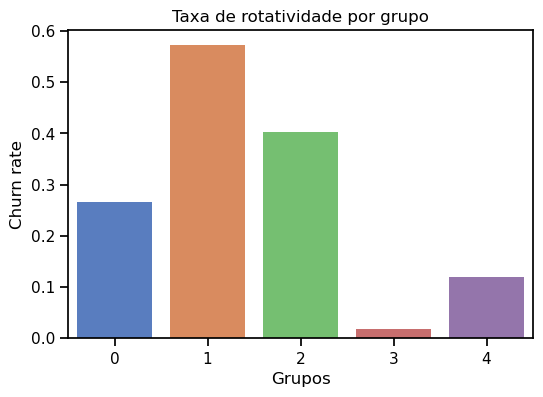

In [25]:
plt.figure(figsize=(6,4))
sns.barplot(churn_rate, palette='muted')
plt.xlabel('Grupos')
plt.ylabel('Churn rate')
plt.title('Taxa de rotatividade por grupo')
plt.show()

Grupo com maior taxa de rotatividade: grupo 1,
Grupo com menores taxas de rotatividade: 3 e 4

#### Passo 5. Chegue a conclusões e faça recomendações básicas sobre trabalhar com clientes

Conforme resultado da análise dos modelos de aprendizado de máquina para previsão de rotatividade (regressão classificação binária) e agrupamento de clientes (não supervisionado k-means), as recomendação para estratégia de interação e retenção de clientes vão de acordo com a importância de cada característica em relação a variavel objetivo encontradas nesses modelos. Portanto as recomendações seriam as seguintes: 

* Recomendo o incentivo para clientes entrarem em contratos mais longos, isso pode ser feito através de desconto na mensalidade, material de treino ou prioridade de acesso a aulas ou tipo de áres de vips ou de ralaxamento pós treino (sauna, piscina e etc...)
* Aumento  e incentivo a participação em aulas de grupos que atraem público mais jovens (menos de 30 anos) 
* Investir mais no marketing nas promoções de indicação de amigos e empresas parceiras 
* Investimento no marketing para pessoas de maior idade, talvez abertura de aulas de grupos voltados a público mais velho